In [1]:
from collections import defaultdict
import itertools
import mthree
import numpy as np
import os
import matplotlib.pyplot as plt
from qiskit import Aer, transpile
from qiskit.quantum_info import SparsePauliOp
from qiskit_nature.circuit.library import FermionicGaussianState
from qiskit_nature.mappers.second_quantization import JordanWignerMapper
from qiskit_nature.converters.second_quantization.qubit_converter import QubitConverter
from mzm_generation import (
    bdg_hamiltonian,
    compute_edge_correlation,
    compute_edge_correlation_measurement_corrected,
    compute_energy,
    compute_energy_measurement_corrected,
    compute_number,
    compute_number_measurement_corrected,
    compute_parity,
    compute_parity_measurement_corrected,
    edge_correlation_op,
    expectation,
    FermionicGaussianStateParameters,
    FermionicGaussianStateTask,
    kitaev_hamiltonian,
    load,
    MeasurementErrorCalibrationTask,
    number_op)

In [2]:
# boilerplate
converter = QubitConverter(mapper=JordanWignerMapper())
simulator_backend = Aer.get_backend("statevector_simulator")

In [3]:
# set parameters

# number of modes
n_modes = 3

# Hamiltonian parameters to consider
tunneling_values = [-1.0]
superconducting_values = [1.0]
chemical_potential_values = np.linspace(1e-8, 3.1, num=20)

# number of shots
shots = 10000

# number of shots for measurement error calibration
measurement_error_calibration_shots = 50000

# qubits
qubits = [0, 1, 2]

# experiment id used for saving data
experiment_id = '2022-01-14T21:59:52.211779_statevector_simulator'

# create plot directory
os.makedirs(f'plots/{experiment_id}', exist_ok=True)

In [4]:
%%time
# analyze results for Hamiltonian expectation
def powerset(items):
    return itertools.chain.from_iterable(
        itertools.combinations(items, k)
        for k in range(len(items) + 1))

tunneling = -1.0
superconducting = 1.0

exact_series = defaultdict(list)
experiment_series = defaultdict(list)
measurement_corrected_series = defaultdict(list)

for chemical_potential in chemical_potential_values:
    # create Hamiltonian
    hamiltonian_quad = kitaev_hamiltonian(
        n_modes,
        tunneling=tunneling,
        superconducting=superconducting,
        chemical_potential=chemical_potential)
    hamiltonian = hamiltonian_quad._fermionic_op()
    hamiltonian_jw = converter.convert(hamiltonian).primitive
    # compute eigenvalues
    transformation_matrix, orbital_energies, constant = hamiltonian_quad.diagonalizing_bogoliubov_transform()
    energy_shift = -0.5 * np.sum(orbital_energies) - constant
    # compute exact and experimental values
    for occupied_orbitals in powerset(range(n_modes)):
        state_params = FermionicGaussianStateParameters(
            n_modes=n_modes,
            tunneling=tunneling,
            superconducting=superconducting,
            chemical_potential=chemical_potential,
            occupied_orbitals=occupied_orbitals)
        # load data
        task = FermionicGaussianStateTask(
            experiment_id=experiment_id,
            shots=shots,
            state_params=state_params)
        data = load(task)
        measurements = data['measurements']
        quasis = {pauli_string: mthree.classes.QuasiDistribution(quasi_dist)
                  for pauli_string, quasi_dist in data['quasis'].items()}
        # exact energy
        exact_energy = np.sum(orbital_energies[list(occupied_orbitals)]) + constant
        exact_series[occupied_orbitals].append(exact_energy + energy_shift) 
        # experimental energy
        experiment_energy = compute_energy(measurements, hamiltonian_jw)
        experiment_series[occupied_orbitals].append(experiment_energy + energy_shift)
        # experimental energy with measurement error mitigation
        measurement_corrected_energy = compute_energy_measurement_corrected(
            quasis, hamiltonian_jw)
        measurement_corrected_series[occupied_orbitals].append(measurement_corrected_energy + energy_shift)

/home/kjs/projects/qiskit-nature/qiskit_nature/operators/second_quantization/quadratic_hamiltonian.py:103: UserWarning: The default value for `display_format` will be changed from 'dense' to 'sparse' in version 0.3.0. Once that happens, you must specify display_format='dense' directly.
  return FermionicOp(terms, register_length=self._n_orbitals)


CPU times: user 390 ms, sys: 33.5 ms, total: 423 ms
Wall time: 630 ms


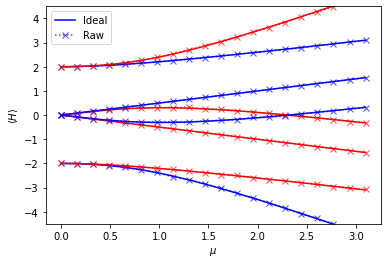

In [5]:
# plot
fig, ax = plt.subplots()
for occupied_orbitals, series in exact_series.items():
    label = 'Ideal' if not occupied_orbitals else None
    color = 'red' if len(occupied_orbitals) % 2 else 'blue'
    ax.plot(chemical_potential_values, series, label=label, color=color)
for occupied_orbitals, series in experiment_series.items():
    label = 'Raw' if not occupied_orbitals else None
    color = 'red' if len(occupied_orbitals) % 2 else 'blue'
    ax.plot(chemical_potential_values, series, 'x:', label=label, color=color, alpha=0.7)
ax.set_xlabel(r'$\mu$')
ax.set_ylabel(r'$\langle H \rangle$')
ax.set_ylim(-4.5, 4.5)
plt.legend()
plt.savefig(f'plots/{experiment_id}/energy_raw.png', dpi=300)
plt.show()

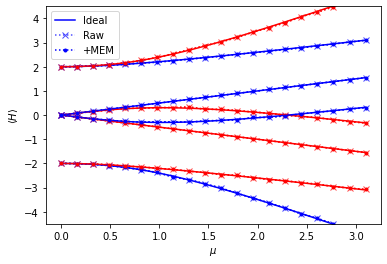

In [6]:
# plot
fig, ax = plt.subplots()
for occupied_orbitals, series in exact_series.items():
    label = 'Ideal' if not occupied_orbitals else None
    color = 'red' if len(occupied_orbitals) % 2 else 'blue'
    ax.plot(chemical_potential_values, series, label=label, color=color)
for occupied_orbitals, series in experiment_series.items():
    label = 'Raw' if not occupied_orbitals else None
    color = 'red' if len(occupied_orbitals) % 2 else 'blue'
    ax.plot(chemical_potential_values, series, 'x:', label=label, color=color, alpha=0.7)
for occupied_orbitals, series in measurement_corrected_series.items():
    label = '+MEM' if not occupied_orbitals else None
    color = 'red' if len(occupied_orbitals) % 2 else 'blue'
    ax.plot(chemical_potential_values, series, '.:', label=label, color=color)
ax.set_xlabel(r'$\mu$')
ax.set_ylabel(r'$\langle H \rangle$')
ax.set_ylim(-4.5, 4.5)
plt.legend()
plt.savefig(f'plots/{experiment_id}/energy_raw_mem.png', dpi=300)
plt.show()

In [7]:
%%time
# analyze results for edge correlation
tunneling = -1.0
superconducting = 1.0

edge_correlation = edge_correlation_op(n_modes)
edge_correlation_jw = converter.convert(edge_correlation)
edge_correlation_dense = edge_correlation_jw.to_matrix()

edge_corr_exact_series = defaultdict(list)
edge_corr_experiment_series = defaultdict(list)
edge_corr_measurement_corrected_series = defaultdict(list)

for chemical_potential in chemical_potential_values:
    # create Hamiltonian
    hamiltonian_quad = kitaev_hamiltonian(
        n_modes,
        tunneling=tunneling,
        superconducting=superconducting,
        chemical_potential=chemical_potential)
    transformation_matrix, _, _ = hamiltonian_quad.diagonalizing_bogoliubov_transform()
    # compute exact and experimental values
    for occupied_orbitals in powerset(range(n_modes)):
        state_params = FermionicGaussianStateParameters(
            n_modes=n_modes,
            tunneling=tunneling,
            superconducting=superconducting,
            chemical_potential=chemical_potential,
            occupied_orbitals=occupied_orbitals)
        # load data
        task = FermionicGaussianStateTask(
            experiment_id=experiment_id,
            shots=shots,
            state_params=state_params)
        data = load(task)
        measurements = data['measurements']
        quasis = {pauli_string: mthree.classes.QuasiDistribution(quasi_dist)
          for pauli_string, quasi_dist in data['quasis'].items()}
        # exact correlation
        circuit = FermionicGaussianState(transformation_matrix, occupied_orbitals)
        transpiled_circuit = circuit.decompose()
        state = simulator_backend.run(transpiled_circuit).result().get_statevector().data
        exact_correlation = np.real(expectation(edge_correlation_dense, state))
        edge_corr_exact_series[occupied_orbitals].append(exact_correlation)
        # experimental correlation
        experiment_correlation = compute_edge_correlation(measurements)
        edge_corr_experiment_series[occupied_orbitals].append(experiment_correlation)
        # experimental correlation with measurement error mitigation
        measurement_corrected_correlation = compute_edge_correlation_measurement_corrected(quasis)
        edge_corr_measurement_corrected_series[occupied_orbitals].append(measurement_corrected_correlation)

CPU times: user 3.55 s, sys: 74.1 ms, total: 3.62 s
Wall time: 3.94 s


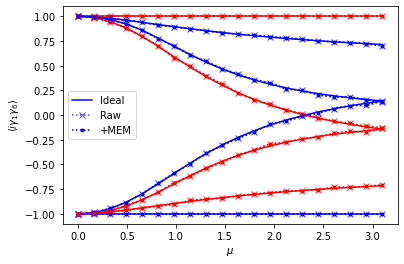

In [8]:
# plot
fig, ax = plt.subplots()
for occupied_orbitals, series in edge_corr_exact_series.items():
    label = 'Ideal' if not occupied_orbitals else None
    color = 'red' if len(occupied_orbitals) % 2 else 'blue'
    ax.plot(chemical_potential_values, series, label=label, color=color)
for occupied_orbitals, series in edge_corr_experiment_series.items():
    label = 'Raw' if not occupied_orbitals else None
    color = 'red' if len(occupied_orbitals) % 2 else 'blue'
    ax.plot(chemical_potential_values, series, 'x:', label=label, color=color, alpha=0.7)
for occupied_orbitals, series in edge_corr_measurement_corrected_series.items():
    label = '+MEM' if not occupied_orbitals else None
    color = 'red' if len(occupied_orbitals) % 2 else 'blue'
    ax.plot(chemical_potential_values, series, '.:', label=label, color=color)
ax.set_xlabel(r'$\mu$')
ax.set_ylabel(r'$\langle i \gamma_1 \gamma_6 \rangle$')
ax.set_ylim(-1.1, 1.1)
plt.legend()
plt.savefig(f'plots/{experiment_id}/edge_correlation_raw_mem.png', dpi=300)
plt.show()

In [9]:
%%time
# analyze results for parity
tunneling = -1.0
superconducting = 1.0

parity_exact_series = defaultdict(list)
parity_experiment_series = defaultdict(list)
parity_measurement_corrected_series = defaultdict(list)

for chemical_potential in chemical_potential_values:
    # create Hamiltonian
    hamiltonian_quad = kitaev_hamiltonian(
        n_modes,
        tunneling=tunneling,
        superconducting=superconducting,
        chemical_potential=chemical_potential)
    transformation_matrix, _, _ = hamiltonian_quad.diagonalizing_bogoliubov_transform()
    W1 = transformation_matrix[:, :n_modes]
    W2 = transformation_matrix[:, n_modes:]
    full_transformation = np.block([[W1, W2], [W2.conj(), W1.conj()]])
    hamiltonian_parity = np.real(np.sign(np.linalg.det(full_transformation)))
    # compute exact and experimental values
    for occupied_orbitals in powerset(range(n_modes)):
        state_params = FermionicGaussianStateParameters(
            n_modes=n_modes,
            tunneling=tunneling,
            superconducting=superconducting,
            chemical_potential=chemical_potential,
            occupied_orbitals=occupied_orbitals)
        # load data
        task = FermionicGaussianStateTask(
            experiment_id=experiment_id,
            shots=shots,
            state_params=state_params)
        data = load(task)
        measurements = data['measurements']
        quasis = {pauli_string: mthree.classes.QuasiDistribution(quasi_dist)
                  for pauli_string, quasi_dist in data['quasis'].items()}
        # exact parity
        exact_parity = (-1) ** len(occupied_orbitals) * hamiltonian_parity
        parity_exact_series[occupied_orbitals].append(exact_parity)
        # experimental parity
        experiment_parity = compute_parity(measurements)
        parity_experiment_series[occupied_orbitals].append(experiment_parity)
        # experimental parity with measurement error mitigation
        measurement_corrected_parity = compute_parity_measurement_corrected(quasis)
        parity_measurement_corrected_series[occupied_orbitals].append(measurement_corrected_parity)

CPU times: user 67.8 ms, sys: 38.4 ms, total: 106 ms
Wall time: 389 ms


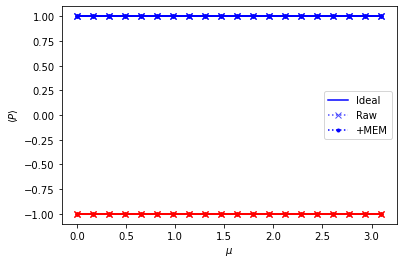

In [10]:
# plot
fig, ax = plt.subplots()
for occupied_orbitals, series in parity_exact_series.items():
    label = 'Ideal' if not occupied_orbitals else None
    color = 'red' if len(occupied_orbitals) % 2 else 'blue'
    ax.plot(chemical_potential_values, series, label=label, color=color)
for occupied_orbitals, series in parity_experiment_series.items():
    label = 'Raw' if not occupied_orbitals else None
    color = 'red' if len(occupied_orbitals) % 2 else 'blue'
    ax.plot(chemical_potential_values, series, 'x:', label=label, color=color, alpha=0.7)
for occupied_orbitals, series in parity_measurement_corrected_series.items():
    label = '+MEM' if not occupied_orbitals else None
    color = 'red' if len(occupied_orbitals) % 2 else 'blue'
    ax.plot(chemical_potential_values, series, '.:', label=label, color=color)
ax.set_xlabel(r'$\mu$')
ax.set_ylabel(r'$\langle P \rangle$')
ax.set_ylim(-1.1, 1.1)
plt.legend()
plt.savefig(f'plots/{experiment_id}/parity_raw_mem.png', dpi=300)
plt.show()

In [11]:
%%time
# analyze results for particle number
tunneling = -1.0
superconducting = 1.0

number = number_op(n_modes)
number_jw = converter.convert(number)
number_dense = number_jw.to_matrix()

number_exact_series = defaultdict(list)
number_experiment_series = defaultdict(list)
number_measurement_corrected_series = defaultdict(list)

for chemical_potential in chemical_potential_values:
    # create Hamiltonian
    hamiltonian_quad = kitaev_hamiltonian(
        n_modes,
        tunneling=tunneling,
        superconducting=tunneling,
        chemical_potential=chemical_potential)
    transformation_matrix, _, _ = hamiltonian_quad.diagonalizing_bogoliubov_transform()
    # compute exact and experimental values
    for occupied_orbitals in powerset(range(n_modes)):
        state_params = FermionicGaussianStateParameters(
            n_modes=n_modes,
            tunneling=tunneling,
            superconducting=superconducting,
            chemical_potential=chemical_potential,
            occupied_orbitals=occupied_orbitals)
        # load data
        task = FermionicGaussianStateTask(
            experiment_id=experiment_id,
            shots=shots,
            state_params=state_params)
        data = load(task)
        measurements = data['measurements']
        quasis = {pauli_string: mthree.classes.QuasiDistribution(quasi_dist)
                  for pauli_string, quasi_dist in data['quasis'].items()}
        # exact number
        circuit = FermionicGaussianState(transformation_matrix, occupied_orbitals)
        transpiled_circuit = circuit.decompose()
        state = simulator_backend.run(transpiled_circuit).result().get_statevector().data
        exact_number = np.real(expectation(number_dense, state))
        number_exact_series[occupied_orbitals].append(exact_number)
        # experimental number
        experiment_number = compute_number(measurements)
        number_experiment_series[occupied_orbitals].append(experiment_number)
        # experimental number with measurement error mitigation
        measurement_corrected_number = compute_number_measurement_corrected(quasis)
        number_measurement_corrected_series[occupied_orbitals].append(measurement_corrected_number)

CPU times: user 3.46 s, sys: 52.3 ms, total: 3.51 s
Wall time: 3.7 s


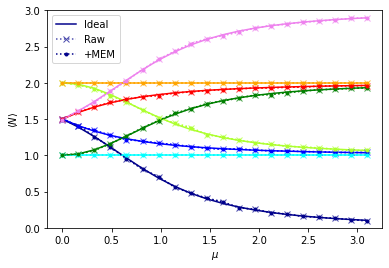

In [12]:
# plot
colors = {
    (): 'darkblue',
    (0,): 'blue',
    (1,): 'cyan',
    (2,): 'greenyellow',
    (0, 1): 'green',
    (0, 2): 'orange',
    (1, 2): 'red',
    (0, 1, 2): 'violet',
}
fig, ax = plt.subplots()
for occupied_orbitals, series in number_exact_series.items():
    label = 'Ideal' if not occupied_orbitals else None
    ax.plot(chemical_potential_values, series, label=label, color=colors[occupied_orbitals])
for occupied_orbitals, series in number_experiment_series.items():
    label = 'Raw' if not occupied_orbitals else None
    ax.plot(chemical_potential_values, series, 'x:', label=label, color=colors[occupied_orbitals], alpha=0.7)
for occupied_orbitals, series in number_measurement_corrected_series.items():
    label = '+MEM' if not occupied_orbitals else None
    ax.plot(chemical_potential_values, series, '.:', label=label, color=colors[occupied_orbitals])
ax.set_xlabel(r'$\mu$')
ax.set_ylabel(r'$\langle N \rangle$')
ax.set_ylim(0, 3)
plt.legend()
plt.savefig(f'plots/{experiment_id}/number.png', dpi=300)
plt.show()

In [13]:
# analyze results for BdG Hamiltonian
tunneling = -1.0
superconducting = 1.0

bdg_series = np.zeros((len(chemical_potential_values), 2 * n_modes))

for i, chemical_potential in enumerate(chemical_potential_values):
    hamiltonian_quad = kitaev_hamiltonian(
        n_modes,
        tunneling=tunneling,
        superconducting=tunneling,
        chemical_potential=chemical_potential)
    hamiltonian_bdg = bdg_hamiltonian(hamiltonian_quad)
    eigs, _ = np.linalg.eigh(hamiltonian_bdg)
    bdg_series[i] = eigs

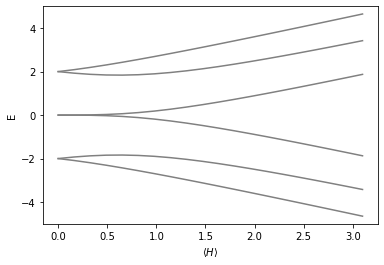

In [14]:
# plot
fig, ax = plt.subplots()

for i in range(2 * n_modes):
    ax.plot(chemical_potential_values, bdg_series[:, i], color='gray')

ax.set_xlabel(r'$\langle H \rangle$')
ax.set_ylabel('E')
ax.set_ylim(-5, 5)
plt.show()